[Pyspark blog](https://bryancutler.github.io/)

[ML w/ Pyspark](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

[GitHub event types](https://developer.github.com/v3/activity/events/types/)

[Churn modeling](https://www.urbanairship.com/blog/churn-prediction-our-machine-learning-model)

[Interpreting Trees](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Binarizer#, OneHotEncoderEstimator, StringIndexer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import helper as h

In [43]:
_data = h.get_merged_data('classification')
cols = _data.columns

_data.head()

% of users dropped 4.698526359485271


Row(login='0loky0', followers_count=0, following_count=1, blog=0, company=0, created_at='2011-05-24 20:15:25+00:00', public_repos_count=7, public_gists_count=0, hireable=1, updated_at='2019-01-09 15:03:59+00:00', time_between_first_last_event='10 days 15:29:06.000000000', last_event='2016-04-15 10:14:03 UTC', first_event='2016-04-04 18:44:57 UTC', frequency=19, second_period_event_count=0, CommitCommentEvent_count=0, CreateEvent_count=5, DeleteEvent_count=0, ForkEvent_count=2, GollumEvent_count=0, IssueCommentEvent_count=0, IssuesEvent_count=0, MemberEvent_count=0, PublicEvent_count=0, PullRequestEvent_count=0, PullRequestReviewCommentEvent_count=0, PushEvent_count=12, ReleaseEvent_count=0, WatchEvent_count=0)

In [62]:
model_name = 'high_frequency'
churn_data = _data.filter((_data.company == 0) & (_data.frequency <= 10)) 

In [63]:
numeric_features = [t[0] for t in churn_data.dtypes if t[1] == 'int']
churn_data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
followers_count,94395,1.1585783145293713,17.098032179815174,0,4165
following_count,94395,1.3520631389374438,8.798072136996435,0,1254
blog,94395,0.06792732665925102,0.25162248644654195,0,1
company,94395,0.0,0.0,0,0
public_repos_count,94381,5.822707960288618,16.978332917128075,0,2196
public_gists_count,94395,0.38078288044917635,3.3295569891662664,0,356
hireable,94395,0.04672916997722337,0.2110592963158292,0,1
frequency,94395,4.325568091530272,2.454779144193786,2,10
second_period_event_count,94395,4.591461412151068,14.44764713299348,0,199


In [64]:
numeric_features.remove('second_period_event_count')
numeric_features.remove('frequency')
print(numeric_features)

['followers_count', 'following_count', 'blog', 'company', 'public_repos_count', 'public_gists_count', 'hireable', 'CommitCommentEvent_count', 'CreateEvent_count', 'DeleteEvent_count', 'ForkEvent_count', 'GollumEvent_count', 'IssueCommentEvent_count', 'IssuesEvent_count', 'MemberEvent_count', 'PublicEvent_count', 'PullRequestEvent_count', 'PullRequestReviewCommentEvent_count', 'PushEvent_count', 'ReleaseEvent_count', 'WatchEvent_count']


## Build PySpark pipeline

In [65]:
stages = []
# binarizer needs double type or it throws an error.
churn_data = churn_data.withColumn("second_period_event_count", 
                                   churn_data.second_period_event_count.cast(DoubleType()))
binarizer = Binarizer(threshold=0.5, 
                      inputCol="second_period_event_count", 
                      outputCol="label")

stages += [binarizer]
assembler = VectorAssembler(inputCols=numeric_features, 
                            outputCol="features").setHandleInvalid("skip")
stages += [assembler]

In [66]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(churn_data)
churn_data = pipelineModel.transform(churn_data)
selectedCols = ['label', 'features'] + cols
churn_data = churn_data.select(selectedCols)
churn_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- login: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- blog: integer (nullable = true)
 |-- company: integer (nullable = true)
 |-- created_at: string (nullable = true)
 |-- public_repos_count: integer (nullable = true)
 |-- public_gists_count: integer (nullable = true)
 |-- hireable: integer (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- time_between_first_last_event: string (nullable = true)
 |-- last_event: string (nullable = true)
 |-- first_event: string (nullable = true)
 |-- frequency: integer (nullable = true)
 |-- second_period_event_count: double (nullable = true)
 |-- CommitCommentEvent_count: integer (nullable = true)
 |-- CreateEvent_count: integer (nullable = true)
 |-- DeleteEvent_count: integer (nullable = true)
 |-- ForkEvent_count: integer (nullable = true)
 |-- GollumEvent_count: integer

In [67]:
# save pipeline
pipeline.write().overwrite().save('pipeline')

In [68]:
examples = pd.DataFrame(churn_data.take(5), columns=churn_data.columns).transpose()
examples

,0,1,2,3,4
label,1,1,0,1,1
features,"(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 4.0, ...","(3.0, 0.0, 1.0, 0.0, 25.0, 1.0, 0.0, 0.0, 0.0,...","(0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, ..."
login,13246864965,1xPdd,353764437,AaronWB,Aarteaga102
followers_count,0,0,0,3,0
following_count,0,0,0,0,0
blog,0,0,0,1,0
company,0,0,0,0,0
created_at,2016-04-14 10:04:50+00:00,2014-07-11 03:45:56+00:00,2016-02-17 07:40:15+00:00,2014-02-11 15:03:04+00:00,2015-09-15 19:59:26+00:00
public_repos_count,3,0,2,25,6
public_gists_count,0,0,0,1,0


### Training/Test split

In [69]:
train, test = churn_data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: {0}".format(train.count()))
print("Test Dataset Count: {0}".format(test.count()))

Training Dataset Count: 65894
Test Dataset Count: 28487


## Logistic Regression

In [70]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)#,
                       #regParam=0.03, elasticNetParam=0.8)
lrModel = lr.fit(train)

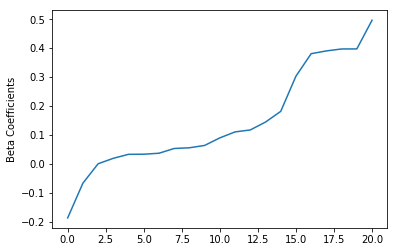

Param(parent='LogisticRegression_5f26c0860ea2', name='featuresCol', doc='features column name')

In [71]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
lrModel.featuresCol

In [72]:
pd.DataFrame({'features': numeric_features, 
              'weights': lrModel.coefficients.values}
            ).sort_values(by='weights', ascending=False)


,features,weights
2,blog,0.496390
6,hireable,0.397239
19,ReleaseEvent_count,0.397055
20,WatchEvent_count,0.390366
12,IssueCommentEvent_count,0.380731
17,PullRequestReviewCommentEvent_count,0.302955
18,PushEvent_count,0.181184
10,ForkEvent_count,0.144278
15,PublicEvent_count,0.117009
7,CommitCommentEvent_count,0.110231


Training set areaUnderROC: 0.8119221863817699


/home/brian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


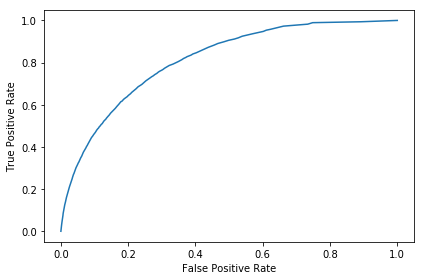

In [73]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()

fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)

ax.plot(roc['FPR'],roc['TPR'])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
#ax.title('ROC Curve')
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


fig.savefig('figures/logistic_regression_ROC.png')

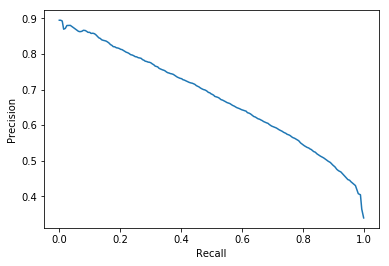

In [74]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [75]:
#lrModel._java_obj.setThreshold(0.5)
print('Threshold: {0}'.format(lrModel._java_obj.getThreshold()))
predictions = lrModel.transform(test)
show_cols = ['followers_count', 'company', 'blog', 
             'label', 'rawPrediction', 'prediction', 'probability']
predictions.select(show_cols).show(10)

Threshold: 0.5
+---------------+-------+----+-----+--------------------+----------+--------------------+
|followers_count|company|blog|label|       rawPrediction|prediction|         probability|
+---------------+-------+----+-----+--------------------+----------+--------------------+
|              1|      0|   1|  0.0|[-1.4149611010180...|       1.0|[0.19545273955646...|
|              1|      0|   1|  0.0|[0.02701652873776...|       0.0|[0.50675372139837...|
|              1|      0|   0|  0.0|[1.29873885698363...|       0.0|[0.78562265822761...|
|              1|      0|   0|  0.0|[-0.4715981075463...|       1.0|[0.38423806280057...|
|              1|      0|   1|  0.0|[0.83621764282847...|       0.0|[0.69766801038058...|
|              2|      0|   0|  0.0|[0.06196119774588...|       0.0|[0.51548534548811...|
|              1|      0|   0|  0.0|[1.19391239406777...|       0.0|[0.76744006243239...|
|              2|      0|   0|  0.0|[1.06963705211842...|       0.0|[0.74452788704902

In [76]:
h.eval_metrics(predictions)

Precision: 0.722
Recall:    0.425
Accuracy:  0.749
F1-score:  0.535


In [77]:
lrModel.write().overwrite().save('lrModel_' + model_name)

## Gradient Boosted Trees

[Gradient Boost vs XGboost](https://datascience.stackexchange.com/questions/16904/gbm-vs-xgboost-key-differences)

In [78]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
h.write_tree_to_file(gbtModel.toDebugString, 'gbt_trees_' + model_name)
predictions = gbtModel.transform(test)
predictions.select(show_cols).show(10)

Saved to fullfile
+---------------+-------+----+-----+--------------------+----------+--------------------+
|followers_count|company|blog|label|       rawPrediction|prediction|         probability|
+---------------+-------+----+-----+--------------------+----------+--------------------+
|              1|      0|   1|  0.0|[-0.4190110820019...|       1.0|[0.30195150255750...|
|              1|      0|   1|  0.0|[0.11351745466296...|       0.0|[0.55651617580887...|
|              1|      0|   0|  0.0|[0.28711305829101...|       0.0|[0.63973775652135...|
|              1|      0|   0|  0.0|[-0.0698889617328...|       1.0|[0.46511230324631...|
|              1|      0|   1|  0.0|[-0.1207449169580...|       1.0|[0.43991923731178...|
|              2|      0|   0|  0.0|[-0.2673943579254...|       1.0|[0.36940069032755...|
|              1|      0|   0|  0.0|[-0.0250590591200...|       1.0|[0.48747309244766...|
|              2|      0|   0|  0.0|[0.29066420600265...|       0.0|[0.64137301660

In [79]:
h.eval_metrics(predictions)

Precision: 0.681
Recall:    0.59
Accuracy:  0.767
F1-score:  0.6323


In [128]:
print(gbtModel.featureImportances.indices)
numeric_features = np.asarray(numeric_features)
pd.DataFrame([numeric_features[gbtModel.featureImportances.indices], 
              gbtModel.featureImportances.values]).T.sort_values(by=[1], ascending=False)

[ 0  1  2  4  5  6  8  9 10 12 13 14 15 16 17 18 20]


,0,1
3,public_repos_count,0.398254
15,PushEvent_count,0.107205
1,following_count,0.106281
9,IssueCommentEvent_count,0.0920631
0,followers_count,0.0546373
6,CreateEvent_count,0.0521989
16,WatchEvent_count,0.0501712
4,public_gists_count,0.0432222
8,ForkEvent_count,0.0355423
10,IssuesEvent_count,0.0329194


In [80]:
'''evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(
    evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))'''

'evaluator = BinaryClassificationEvaluator()\nprint("Test Area Under ROC: " + str(\n    evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))'

## Random forest classification

In [20]:
'''rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
h.write_tree_to_file(rfModel.toDebugString, 'rf_trees_' + model_name)
predictions = rfModel.transform(test)
predictions.select(show_cols).show(10)
h.eval_metrics(predictions)'''

## Grid search with cross validation

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)